# Exploring and Visualizing BioSCape LVIS Data
## BioSCape Data Skills Workshop: From the Field to the Image
![Bioscape](../../bioscape.png)

[**BioSCape**](https://www.bioscape.io/), the Biodiversity Survey of the Cape, is NASA’s first biodiversity-focused airborne and field campaign that was conducted in South Africa in 2023. BioSCape’s primary objective is to study the structure, function, and composition of the region’s ecosystems, and how and why they are changing. 

BioSCape's airborne dataset is unprecedented, with `AVIRIS-NG`, `PRISM`, and `HyTES` imaging spectrometers capturing spectral data across the UV, visible and infrared at high resolution and `LVIS` acquiring coincident full-waveform lidar. BioSCape's `field dataset` is equally impressive, with 18 PI-led projects collecting data ranging from the diversity and phylogeny of plants, kelp and phytoplankton, eDNA, landscape acoustics, plant traits, blue carbon accounting, and more

This workshop will equip participants with the skills to find, subset, and visualize the various BioSCape field and airborne (imaging spectroscopy and full-waveform lidar) data sets. Participants will learn data skills through worked examples in terrestrial and aquatic ecosystems, including: wrangling lidar data, performing band math calculations, calculating spectral diversity metrics, machine learning and image classification, and mapping functional traits using partial least squares regression. The workshop format is a mix of expert talks and interactive coding notebooks and will be run through the BioSCape Cloud computing environment.

**Date:** October 9 - 11, 2024 Cape Town, South Africa</center>

**Host:** NASA’s Oak Ridge National Laboratory Distributed Active Archive Center (ORNL DAAC), in close collaboration with BioSCape, the South African Environmental Observation Network (SAEON), the University of Wisconsin Madison (Phil Townsend), The Nature Conservancy (Glenn Moncrieff), the University of California Merced (Erin Hestir), the University of Cape Town (Jasper Slingsby), Jet Propulsion Laboratory (Kerry Cawse-Nicholson), and UNESCO.

**Instructors:** 
- In-person contributors: Anabelle Cardoso, Erin Hestir, Phil Townsend, Henry Frye, Glenn Moncrieff, Jasper Slingsby, Michele Thornton, Rupesh Shrestha
- Virtual contributors: Kerry Cawse-Nicholson, Nico Stork, Kyle Kovach

**Audience:** This training is primarily intended for government natural resource management agency representatives and field technicians in South Africa, as well as local academics and students, especially those connected to the BioSCape Team. 

## Overview

This tutorial will demonstrate accessing and visualizing **Land, Vegetation, and Ice Sensor (LVIS)** data available on the BioSCape SMCE. LVIS is an airborne, wide-swath imaging full-waveform laser altimeter. LVIS collects in a 1064 nm-wavelength (near infrared) range with 3 detectors mounted in an airborne platform, flown typically ~10 km above the ground producing a data swath of 2km wide with 7-10 m footprints. More information about the LVIS instrument is [here](https://lvis.gsfc.nasa.gov/Home/instrumentdetails.html).

The LVIS instrument has been flown above several regions of the world since 1998. The LVIS flights were collected for the [BioSCAPE campaigns](https://lvis.gsfc.nasa.gov/Data/Maps/SouthAfrica2023Map.html) from `01 Oct 2023` through `30 Nov 2023`.

There are three LVIS BioSCape data products currently available and archived at [NSIDC DAAC](https://search.earthdata.nasa.gov/search?q=LVIS&qt=2023-10-20T00%3A00%3A00.000Z%2C2023-11-15T23%3A59%3A59.999Z&fi=LVIS-Camera!LVIS&fdc=National%2BSnow%2Band%2BIce%2BData%2BCenter%2BDistributed%2BActive%2BArchive%2BCenter%2B%2528NSIDC%2BDAAC%2529&fpj=BioSCape&_ga=2.63606251.53278573.1721067437-1362124365.1714395655&_gl=1*q0ghrk*_ga*MTM2MjEyNDM2NS4xNzE0Mzk1NjU1*_ga_LQ2P0SNJCZ*MTcyMTU5NTQ4Ni4xMjMuMS4xNzIxNTk1NjkxLjAuMC4w)

| Dataset | Dataset DOI | 
| -------- | --- |
| LVIS L1A Geotagged Images V001 | [10.5067/NE5KKKBAQG44](https://doi.org/10.5067/NE5KKKBAQG44) |
| LVIS Facility L1B Geolocated Return Energy Waveforms V001 | [10.5067/XQJ8PN8FTIDG](https://doi.org/10.5067/XQJ8PN8FTIDG) |
| LVIS Facility L2 Geolocated Surface Elevation and Canopy Height Product V001 | [10.5067/VP7J20HJQISD](https://doi.org/10.5067/VP7J20HJQISD) |

For this tutorial, we'll examine the `LVIS L2 Geolocated Surface Elevation and Canopy Height Product V001`

- **Citation:** Blair, J. B. & Hofton, M. (2020). LVIS Facility L2 Geolocated Surface Elevation and Canopy Height Product, Version 1 [Data Set]. Boulder, Colorado USA. NASA National Snow and Ice Data Center Distributed Active Archive Center. https://doi.org/10.5067/VP7J20HJQISD.
- **User Guide** [LVIS Facility L2 Geolocated Surface Elevation and Canopy Height Product, Version ](https://nsidc.org/sites/default/files/lvisf2-v001-userguide_2_0.pdf)1

![LVIS Waveform](assets/lvis_waveform.png)
**Figure:** Sample LVIS product waveforms illustrating possible distributions of reflected light (Blair et al., 2020)


In [1]:
from glob import glob
import numpy as np
import pandas as pd
import earthaccess
import geopandas as gpd
import requests as re
import s3fs
import h5py
from os import path
from datetime import datetime
from shapely.geometry import Polygon, MultiPolygon
import matplotlib.pyplot as plt
from shapely.geometry import box
from harmony import BBox,Client, Collection, Request, LinkType

In [2]:
# esri background basemap for maps
xyz = "https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}"
attr = "ESRI"

The LVIS data from the BioSCape project are available at the SMCE S3 bucket. Let's list the LVIS folders at the BioSCape SMCE.

In [3]:
s3 = s3fs.S3FileSystem(anon=False)
lvis = s3.ls('bioscape-data/LVIS')
lvis

['bioscape-data/LVIS/L1B', 'bioscape-data/LVIS/L2']

Both LVIS L1B and L2 products are available at the S3 bucket. 

## Structure LVIS L1B Geolocated Waveform

First, let's find out how many L1B files are there on the SMCE.

In [4]:
count_l1 = len(s3.ls('bioscape-data/LVIS/L1B'))
print(f"There are {count_l1} LVIS L1 granules")

There are 2328 LVIS L1 granules


Now, we go ahead and open a file to look at its structure.

In [5]:
l1_first = 'bioscape-data/LVIS/L1B/LVISF1B_BioSCape2023_1109_R2404_047611.h5'
with s3.open(l1_first, mode='rb') as fh:
    with h5py.File(fh) as hf:
        for v in list(hf.keys()):
            if v != "ancillary_data":
                print(f"- {v} : {hf[v].attrs['description'][0].decode('utf-8')}")

- AZIMUTH : Azimuth angle of laser beam
- INCIDENTANGLE : Off-nadir incident angle of laser beam
- LAT0 : Latitude of the highest sample of the return waveform (degrees north) 
- LAT1215 : Latitude of the lowest sample of the return waveform (degrees north) 
- LFID : LVIS file identification.  Together with 'LVIS shotnumber' these are a unique identifier for every LVIS laser shot. Format is XXYYYYYZZZ where XX identifies instrument version, YYYYY is the Modified Julian Date of the flight departure day, ZZZ represents file number.
- LON0 : Longitude of the highest sample of the return waveform (degrees east)
- LON1215 : Longitude of the lowest sample of the return waveform (degrees east) 
- RANGE : Distance along laser path from the instrument to the ground
- RXWAVE : Returned waveform (1216 samples long)
- SHOTNUMBER : Laser shot number assigned during collection.  Together with 'LVIS LFID' provides a unique identifier to every LVIS laser shot.
- SIGMEAN : Signal mean noise level, calc

In [6]:
with s3.open(l1_first, mode='rb') as fh:
    with h5py.File(fh) as hf:
        l_lat = hf['LAT1215'][:]
        l_lon = hf['LON1215'][:]
        l_range = hf['Z1215'][:] # ground elevation
        shot = hf['SHOTNUMBER'][:] # ground elevation
geo_arr = list(zip(shot, l_range,l_lat,l_lon))
l1b_df = pd.DataFrame(geo_arr, columns=["shot_number", "elevation", "lat", "lon"])
l1b_df

shot_number  elevation        lat        lon
0          82378820  59.477188 -34.699020  19.651972
1          82378821  58.855934 -34.699012  19.651895
2          82378822  59.752430 -34.699084  19.651964
3          82378823  59.403404 -34.699076  19.651888
4          82378824  60.092033 -34.699148  19.651957
...             ...        ...        ...        ...
349995     82729294  -8.561060 -34.678439  19.528331
349996     82729295  -9.040883 -34.678432  19.528254
349997     82729296  -8.609493 -34.678375  19.528340
349998     82729297  -8.090749 -34.678367  19.528263
349999     82729298  -8.993920 -34.678310  19.528348

[350000 rows x 4 columns]

In [7]:
l1b_gdf = gpd.GeoDataFrame(l1b_df, crs="EPSG:4326",
                           geometry=gpd.points_from_xy(l1b_df.lon, 
                                                       l1b_df.lat))
l1b_gdf.sample(frac=0.01).explore("elevation", cmap = "plasma", tiles=xyz, attr=attr)

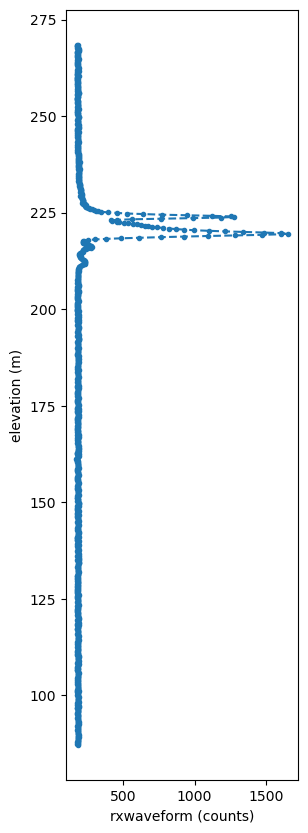

In [8]:
i = np.where(shot==82446258)[0][0]
with s3.open(l1_first, mode='rb') as fh:
    with h5py.File(fh) as hf:
        rxwaveform = hf['RXWAVE'][i, :] # waveform
        elev_1215 = hf['Z1215'][i] # elevation ground
        elev_0 = hf['Z0'][i] # elevation top
c = len(rxwaveform) #
elev = np.linspace(elev_1215, elev_0, num=c)
# plot
plt.rcParams["figure.figsize"] = (3,10)
plt.xlabel("rxwaveform (counts)")
plt.ylabel("elevation (m)")
plt.plot(rxwaveform, elev, linestyle='--', marker='.',)
plt.show()

## Structure of LVIS L2 Canopy Height Product
First, let's see how many L2 files are there at BioSCape SMCE.

In [9]:
count_l2 = len(s3.ls('bioscape-data/LVIS/L2'))
print(f"There are {count_l2} LVIS L2 granules")

There are 2327 LVIS L2 granules


Now, we'll go ahead and open a file to look at it's structure.

In [10]:
l2_first = 'bioscape-data/LVIS/L2/LVISF2_BioSCape2023_1109_R2404_047611.TXT'
with s3.open(l2_first, 'rb') as f:
    head = [next(f) for _ in range(15)]
    print(head)

[b"# Level2 (v2.0.5) data set collected by NASA's Land, Vegetation and Ice Sensor (LVIS) Facility in October-November 2023 as part of NASA's BioSCape Field Campaign. This file contains elevation,\n", b"# height and surface structure metrics derived from LVIS's geolocated laser return waveform. The corresponding spatially geolocated laser return waveforms are contained in the Level 1B data set.\n", b'# For supporting information please visit https://lvis.gsfc.nasa.gov/Data/Maps/SouthAfrica2023Map.html. LVIS-targeted data collections occurred at flight altitudes of ~7 km above the surface from\n', b'# the NASA G-V, however data collections also occurred at lower altitudes. The "Range" parameter can be used to determine flight altitude. Note: Two alternate ground elevations options are provided\n', b'# in order to provide flexibility for local site conditions; if selected for use, adjust the values of the RH parameters accordingly. Please consult the User Guide for further information. Th

LVIS L2A files have a number of lines as header as shown above. Let's define a python function to read the number of header rows.

In [11]:
def get_line_number(filename):
    """find number of header rows in LVIS L2A"""
    count = 0
    with s3.open(filename, 'rb') as f:
        for line in f:
            if line.startswith(b'#'):
                count = count + 1
                columns = line[1:].split()
            else:
                return count, columns

In [12]:
h_no, col_names = get_line_number(l2_first)
with s3.open(l2_first, 'rb') as f:
    l2a_df = pd.read_csv(f, skiprows=h_no, header=None, engine='python', sep=r'\s+')
    l2a_df.columns =  [x.decode() for x in col_names]
l2a_df

LFID  SHOTNUMBER         TIME       GLON       GLAT      ZG  \
0       1960257687    82378820  47611.75433  19.651985 -34.699046   99.55   
1       1960257687    82378821  47611.75458  19.651909 -34.699038   99.57   
2       1960257687    82378822  47611.75483  19.651978 -34.699109   99.91   
3       1960257687    82378823  47611.75508  19.651902 -34.699102   99.93   
4       1960257687    82378824  47611.75533  19.651970 -34.699173  100.21   
...            ...         ...          ...        ...        ...     ...   
349995  1960257689    82729294  47699.37382  19.528347 -34.678446   32.62   
349996  1960257689    82729295  47699.37407  19.528270 -34.678439   32.26   
349997  1960257689    82729296  47699.37432  19.528356 -34.678382   32.57   
349998  1960257689    82729297  47699.37457  19.528279 -34.678375   32.49   
349999  1960257689    82729298  47699.37482  19.528364 -34.678318   32.62   

        ZG_ALT1  ZG_ALT2       HLON       HLAT  ...  RH99  RH100  AZIMUTH  \
0         99.55    99.55  19.651985 -34.699046  ...  0.86   1.23   336.95   
1         99.57    99.57  19.651909 -34.699038  ...  0.86   1.20   336.26   
2         99.91    99.91  19.651978 -34.699109  ...  0.82   1.20   336.57   
3         99.93    99.93  19.651902 -34.699102  ...  0.90   1.27   335.87   
4        100.21   100.21  19.651970 -34.699173  ...  0.82   1.20   336.16   
...         ...      ...        ...        ...  ...   ...    ...      ...   
349995    32.62    32.62  19.528347 -34.678446  ...  0.75   1.12   298.96   
349996    32.26    32.26  19.528270 -34.678439  ...  0.74   1.30   298.38   
349997    32.57    32.57  19.528356 -34.678382  ...  0.71   1.16   300.44   
349998    32.49    32.49  19.528279 -34.678375  ...  0.71   1.16   299.82   
349999    32.62    32.62  19.528364 -34.678318  ...  0.72   1.17   301.87   

        INCIDENTANGLE    RANGE  COMPLEXITY  SENSITIVITY  CHANNEL_ZT  \
0               4.480  6340.45       0.250        0.955           2   
1               4.511  6339.85       0.241        0.941           2   
2               4.423  6339.25       0.291        0.944           2   
3               4.455  6340.00       0.265        0.953           2   
4               4.368  6338.05       0.255        0.949           2   
...               ...      ...         ...          ...         ...   
349995          2.287  6392.51       0.076        0.980           1   
349996          2.346  6392.81       0.076        0.991           1   
349997          2.312  6392.96       0.174        0.987           1   
349998          2.370  6392.21       0.076        0.981           1   
349999          2.339  6392.51       0.116        0.987           1   

        CHANNEL_ZG  CHANNEL_RH  
0                2           2  
1                2           2  
2                2           2  
3                2           2  
4                2           2  
...            ...         ...  
349995           1           1  
349996           2           1  
349997           1           1  
349998           1           1  
349999           2           1  

[350000 rows x 45 columns]

Let's print LVIS L2 variable names.

In [13]:
l2a_df.columns.values

array(['LFID', 'SHOTNUMBER', 'TIME', 'GLON', 'GLAT', 'ZG', 'ZG_ALT1',
       'ZG_ALT2', 'HLON', 'HLAT', 'ZH', 'TLON', 'TLAT', 'ZT', 'RH10',
       'RH15', 'RH20', 'RH25', 'RH30', 'RH35', 'RH40', 'RH45', 'RH50',
       'RH55', 'RH60', 'RH65', 'RH70', 'RH75', 'RH80', 'RH85', 'RH90',
       'RH95', 'RH96', 'RH97', 'RH98', 'RH99', 'RH100', 'AZIMUTH',
       'INCIDENTANGLE', 'RANGE', 'COMPLEXITY', 'SENSITIVITY',
       'CHANNEL_ZT', 'CHANNEL_ZG', 'CHANNEL_RH'], dtype=object)

Key variables:
- The `GLAT` and `GLON` variables provide coordinates of the lowest detected mode within the LVIS waveform.
- The `RHXX` variables provide height above the lowest detected mode at which XX percentile of the waveform energy.
- `RANGE` provides the distance from the instrument to the ground.
- `SENSITIVITY` provides sensitivity metric for the return waveform.
- `ZG`,`ZG_ALT1`, `ZG_ALT2`: Mean elevation of the lowest detected mode using alternate 1/2 mode detection settings. The alternative `ZG` to use to adjust the RH parameters for local site conditions.

More information about the variables are provided in the [user guide](https://nsidc.org/sites/default/files/lvisf2-v001-userguide_2_0.pdf).

Let's select the particular shot we are interested in.

In [14]:
l2a_shot_df = l2a_df[l2a_df['SHOTNUMBER'] == 82446258]
l2a_shot_df

LFID  SHOTNUMBER         TIME       GLON       GLAT      ZG  \
67405  1960257687    82446258  47628.61402  19.627168 -34.703296  131.79   

       ZG_ALT1  ZG_ALT2       HLON       HLAT  ...   RH99  RH100  AZIMUTH  \
67405   131.79   131.79  19.627174 -34.703288  ...  11.41  12.79   209.65   

       INCIDENTANGLE    RANGE  COMPLEXITY  SENSITIVITY  CHANNEL_ZT  \
67405          5.433  6319.34       0.312        0.993           1   

       CHANNEL_ZG  CHANNEL_RH  
67405           1           1  

[1 rows x 45 columns]

Now, we can plot the RH metrics with elevation.

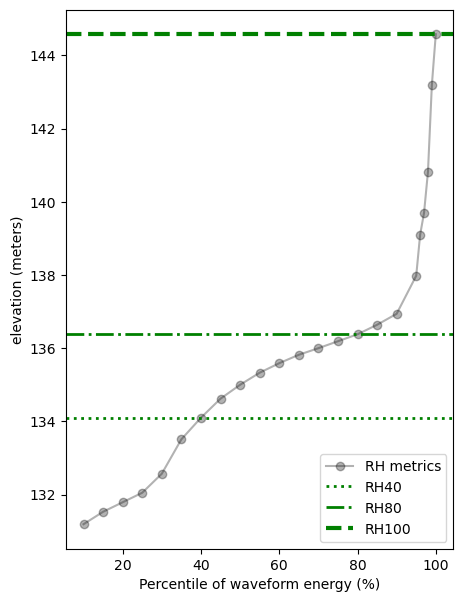

In [15]:
elev_zg = l2a_shot_df.ZG.values[0]
elev_zh = l2a_shot_df.ZH.values[0]
rh40 = l2a_shot_df.RH40.values[0]
rh80 = l2a_shot_df.RH80.values[0]
rh100 = l2a_shot_df.RH100.values[0]
rh = l2a_shot_df.filter(like ='RH').drop('CHANNEL_RH', axis=1).values.tolist()[0]

# plotting
plt.rcParams["figure.figsize"] = (5,7)
rh_vals = l2a_shot_df.filter(like = 'RH').columns[:-1].str.strip('RH').astype(int).tolist()
fig, ax1 = plt.subplots()
ax1.plot(rh_vals, elev_zg+rh, alpha=0.3, marker='o', color='black', label='RH metrics' )
ax1.axhline(y=elev_zg+rh40,  color='g', linestyle='dotted', linewidth=2, label='RH40')
ax1.axhline(y=elev_zg+rh80,  color='g', linestyle='-.', linewidth=2, label='RH80')
ax1.axhline(y=elev_zg+rh100,  color='g', linestyle='--', linewidth=3, label='RH100')
ax1.set_xlabel("Percentile of waveform energy (%)")
ax1.set_ylabel("elevation (meters)")
ax1.legend(loc="lower right")
plt.show()

## Search LVIS L2A granules over Bioscape Campaign
We will use `earthaccess` module to search the LVIS granules using their bounding polygons.

In [16]:
temporal = ("2023-10-01", "2023-11-30") # Bioscape campaign dates
doi = "10.5067/VP7J20HJQISD" # LVIS L2A doi
granules = earthaccess.search_data(
    count=-1, # needed to retrieve all granules
    doi=doi,
    temporal=temporal
)

Granules found: 2328


There are 2328 granules LVIS L2 product found for the time period.
### Plot LVIS Bioscape Campaigns
Lets first define two functions that we can use to plot the search results above over a basemap.

In [17]:
def convert_umm_geometry(gpoly):
    """converts UMM geometry to multipolygons"""
    multipolygons = []
    for gl in gpoly:
        ltln = gl["Boundary"]["Points"]
        points = [(p["Longitude"], p["Latitude"]) for p in ltln]
        multipolygons.append(Polygon(points))
    return MultiPolygon(multipolygons)

def convert_list_gdf(datag):
    """converts List[] to geopandas dataframe"""
    # create pandas dataframe from json
    df = pd.json_normalize([vars(granule)['render_dict'] for granule in datag])
    # keep only last string of the column names
    df.columns=df.columns.str.split('.').str[-1]
    # convert polygons to multipolygonal geometry
    df["geometry"] = df["GPolygons"].apply(convert_umm_geometry)
    # return geopandas dataframe
    return gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")

Now, we will convert the JSON return from the `earthaccess` granule search into a geopandas dataframe so we could plot over an ESRI basemap. 

In [18]:
gdf = convert_list_gdf(granules)
#plot
gdf[['BeginningDateTime','geometry']].explore(tiles=xyz, attr=attr)

The above shows the flight lines of all LVIS collection during the BioSCape campaign in 2023.
### Burned and Unburned Areas
The following are the burned and unburned sites at Cape Penninsula.

In [19]:
poly_gdf = gpd.read_file("assets/burned_unburned_sites.json", crs="EPSG:4326")
# bounding box
bounding_box = poly_gdf.total_bounds
# plot
m1 = poly_gdf.explore(categorical=True, column='description', cmap='Paired', 
                      tiles=xyz, attr=attr, marker_kwds={'radius':10})
m1

Print the `poly_gdf` geopandas dataframe.

In [20]:
poly_gdf

Name description  \
0                                  Milkwood forest    unburned   
1             Tall proteoid fynbos on marine sands    unburned   
2                          Low wet restioid fynbos    unburned   
3                          Low wet restioid fynbos      burned   
4  Dry fynbos on ridge with sparse tall Proteaceae      burned   
5  Dry fynbos on ridge with sparse tall Proteaceae    unburned   

                     geometry  
0  POINT (18.41627 -34.31636)  
1  POINT (18.43615 -34.30710)  
2  POINT (18.43210 -34.31315)  
3  POINT (18.42820 -34.31069)  
4  POINT (18.43254 -34.31609)  
5  POINT (18.42938 -34.31610)

The above shows some burned and unburned sites around Cape Point. Milkwood forest has the tallest vegetation (±5m), followed by Tall proteoid (3-4m). The other four sites show pairs of very low vegetation (0.5-1.5m) across a scar from an old fire (March 2016). The wet restioid should be uniformly low, while the Dry fynbos has sparse taller shrubs. 

### Search LVIS L2A granules over the burned and unburned sites
Let's search for LVIS L2A granules that are within the bounds of the above sites.

In [21]:
granules = earthaccess.search_data(
    count=-1, # needed to retrieve all granules
    doi=doi, # LVIS L2A doi
    temporal=temporal, # Bioscape campaign dates
    bounding_box = tuple(poly_gdf.total_bounds.tolist())
)

Granules found: 11


Let's check when these LVIS flights were flown.

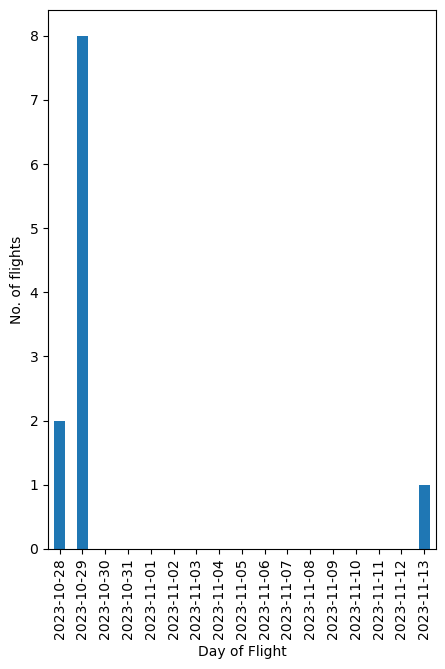

In [22]:
gdf = convert_list_gdf(granules)
gdf['BeginningDateTime'] = pd.to_datetime(gdf['BeginningDateTime'])
gdf_daily = gdf.resample(rule='D', on='BeginningDateTime')['concept-id'].nunique()
gdf_daily.index = pd.to_datetime(gdf_daily.index).date
gdf_daily.plot(kind="bar", xlabel="Day of Flight", ylabel="No. of flights")
plt.show()

For simplicity, we will limit the granules from the LVIS flights for a single date.  Let's plot these flight lines over a basemap.

In [23]:
lvis_day = '2023-10-29'
gdf['BeginningDateTime'] = gdf['BeginningDateTime'].astype(str)
gdf = gdf[gdf['BeginningDateTime'].str.startswith(lvis_day)]
gdf[['BeginningDateTime','geometry']].explore(tiles=xyz, attr=attr, 
                                              style_kwds={'fillOpacity':0.1})

### Build the granule names for BioSCape SMCE S3 access

In the above section, we retrieved the overlapping granules using the `earthaccess` module, which will show the granule download links of the NASA NSIDC DAAC. 

In [24]:
granules[1].data_links()

['https://n5eil01u.ecs.nsidc.org/DP6/ICEBRIDGE/LVISF2.001/2023.10.28/LVISF2_BioSCape2023_1028_R2404_051949.TXT']

In the following codes, we will replace the overlapping granule names with the one from BioSCape S3 bucket. 

In [25]:
lvis_f = []
for s in gdf.index:
    lvis_f.append(path.join('s3://bioscape-data/LVIS/L2/', 
                            path.basename(granules[s].data_links()[0])))
lvis_f

['s3://bioscape-data/LVIS/L2/LVISF2_BioSCape2023_1029_R2404_037983.TXT',
 's3://bioscape-data/LVIS/L2/LVISF2_BioSCape2023_1029_R2404_038553.TXT',
 's3://bioscape-data/LVIS/L2/LVISF2_BioSCape2023_1029_R2404_039707.TXT',
 's3://bioscape-data/LVIS/L2/LVISF2_BioSCape2023_1029_R2404_039795.TXT',
 's3://bioscape-data/LVIS/L2/LVISF2_BioSCape2023_1029_R2404_040388.TXT',
 's3://bioscape-data/LVIS/L2/LVISF2_BioSCape2023_1029_R2404_041561.TXT',
 's3://bioscape-data/LVIS/L2/LVISF2_BioSCape2023_1029_R2404_043943.TXT',
 's3://bioscape-data/LVIS/L2/LVISF2_BioSCape2023_1029_R2404_044034.TXT']

### Read LVIS L2A Files

Now, we can read the LVIS L2A files from the S3 bucket into a pandas dataframe.

In [26]:
# create a buffer around fire sites
poly_utm = poly_gdf.to_crs("EPSG:22234") # UTM 34 S
poly_utm.geometry = poly_utm.geometry.buffer(100) # 100m buffer
poly_wgs_gdf = poly_utm.to_crs("EPSG:4326")

# read the LVIS L2A files
lvis_l2a = []
for f in lvis_f:
    h_no, col_names = get_line_number(f)
    temp_df = pd.read_csv(f, skiprows=h_no, header=None, 
                          engine='python', sep=r'\s+')
    temp_df.columns =  [x.decode() for x in col_names]
    temp_gdf = gpd.GeoDataFrame(temp_df, 
                                geometry=gpd.points_from_xy(temp_df.GLON, 
                                                            temp_df.GLAT),
                                crs="EPSG:4326")
    temp_sub = gpd.sjoin(temp_gdf, poly_wgs_gdf, predicate='within')
    if not temp_sub.empty:
        print(f'Subsetting {path.basename(f)}')
        lvis_l2a.append(temp_sub)
lvis_l2a_gdf = pd.concat(lvis_l2a)

Subsetting LVISF2_BioSCape2023_1029_R2404_037983.TXT
Subsetting LVISF2_BioSCape2023_1029_R2404_038553.TXT
Subsetting LVISF2_BioSCape2023_1029_R2404_039795.TXT
Subsetting LVISF2_BioSCape2023_1029_R2404_040388.TXT
Subsetting LVISF2_BioSCape2023_1029_R2404_041561.TXT
Subsetting LVISF2_BioSCape2023_1029_R2404_043943.TXT


### Height of Top Canopy
Let's plot RH100 (height of top canopy) values in a map.

In [27]:
cols = ['RH100', 'Name', 'description', 'geometry']
lvis_l2a_gdf[cols].explore(
    "RH100", cmap = "YlGn", alpha=0.5, radius=10, legend=True)

As we can see in the map above, the "Tall proteoid fynbos (unburned)" and "Milwood forest (unburned)" sites appear to have taller vegetation.

### Relative Height Distribution of Burned vs Unburned sites
We can generate a plot of RH metrics to check if the vegetation height across the percentile of waveform energy indicates the same. 

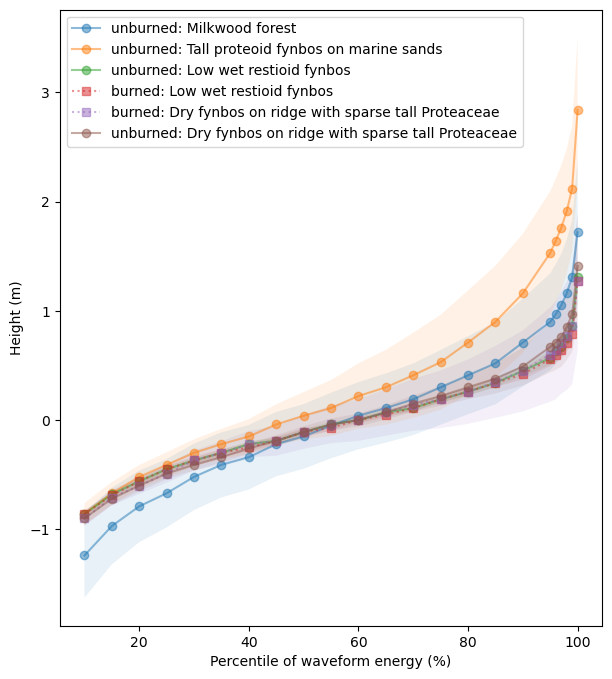

In [28]:
fig, ax = plt.subplots(figsize=(7, 8))
for i in poly_gdf.index:
    pdesc = poly_gdf.loc[i].description
    pname = poly_gdf.loc[i].Name
    desc_df = lvis_l2a_gdf[lvis_l2a_gdf.description == pdesc]
    plot_df = desc_df[desc_df.Name == pname]
    plot_df = plot_df.filter(like='RH').drop('CHANNEL_RH', axis=1).T
    plot_df.index = plot_df.index.str.strip('RH').astype(int)
    style = 's:'
    if pdesc == "unburned":
        style = 'o-'
    std_df = plot_df.std(axis=1)
    median_df = plot_df.median(axis=1)
    median_df.plot(ax=ax, alpha=0.5, style=style, label=f"{pdesc}: {pname}")
    ax.fill_between(plot_df.index, median_df - std_df, 
                    median_df + std_df, alpha=0.1)

    plt.legend()
ax.set_xlabel("Percentile of waveform energy (%)")
ax.set_ylabel("Height (m)")
plt.show()

In [29]:
# exporting 
# lvis_l2a_gdf.geometry.to_file('lvis2.geojson', driver="GeoJSON")
# lvis_l2a_gdf.to_csv('lvis.csv')

## GEDI L2A Canopy Height Metrics
This section of the tutorial will demonstrate how to directly access and subset the GEDI L2A canopy height metrics using [NASA’s Harmony Services](https://harmony.earthdata.nasa.gov) and compute a summary of aboveground biomass density for a forest reserve. The Harmony API allows seamless access and production of analysis-ready Earth observation data across different DAACs by enabling cloud-based spatial, temporal, and variable subsetting and data conversions. The GEDI datasets are available from the Harmony API.

We will use NASA’s Harmony Services to retrieve the GEDI L2A dataset and canopy heights (`RH100`) for the burned and unburned plots . The Harmony API allows access to selected variables for the dataset within the spatial-temporal bounds without having to download the whole data file.

### Dataset
The GEDI Level 2A Geolocated Elevation and Height Metrics product [GEDI02_A](https://doi.org/10.5067/GEDI/GEDI02_A.002) provides waveform interpretation and extracted products from eachreceived waveform, including ground elevation, canopy top height, and relative height (RH) metrics. GEDI datasets are available for the period starting 2019-04-17 and covers 52 N to 52 S latitudes. GEDI L2A data files are natively in HDF5 format.

### Authentication
NASA Harmony API requires [NASA Earthdata Login (EDL)](https://urs.earthdata.nasa.gov/). You can use the `earthaccess` Python library to set up authentication. Alternatively, you can also login to `harmony_client` directly by passing EDL authentication as the following in the Jupyter Notebook itself:
```
harmony_client = Client(auth=("your EDL username", "your EDL password"))
```

### Create Harmony Client Object
First, we create a Harmony Client object. If you are passing the EDL authentication, please do as shown above with the auth parameter.

In [30]:
harmony_client = Client()

### Retrieve Concept ID
Now, let’s retrieve the `Concept ID` of the GEDI L2A dataset. The `Concept ID` is NASA Earthdata’s unique ID for its dataset.

In [31]:
def get_concept_id(doi):
    """get concept id from DOI using CMR API"""
    doisearch = f'https://cmr.earthdata.nasa.gov/search/collections.json?doi={doi}' 
    return re.get(doisearch).json()['feed']['entry'][0]['id']

concept_l2a = get_concept_id('10.5067/GEDI/GEDI02_A.002') # GEDI L2A DOI
print(f"{concept_l2a}")

C2142771958-LPCLOUD


### Define Request Parameters
Let’s create a Harmony Collection object with the concept_id retrieved above. We will also define the GEDI L2A RH variables and temporal range.

In [32]:
# harmony collection
collection_l2a = Collection(id=concept_l2a)

def create_var_names(variables):
    # gedi beams
    beams = ['BEAM0000', 'BEAM0001', 'BEAM0010', 'BEAM0011', 'BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']
    # combine variables and beam names
    return [f'/{b}/{v}' for b in beams for v in variables]

# gedi variables
variables_l2a = create_var_names(['rh', 'quality_flag'])

# time range
temporal_range = {'start': datetime(2019, 4, 17), 
                  'stop': datetime(2023, 3, 31)}

# bounding box for Harmony
b = poly_gdf.total_bounds
bounding_box = BBox(w=b[0], s=b[1], e=b[2], n=b[3])

### Create and Submit Harmony Request
Now, we can create a Harmony request with variables, temporal range, and bounding box and submit the request using the Harmony client object. We will use the `download_all` method, which uses a multithreaded downloader and returns a [concurrent future](https://docs.python.org/3/library/concurrent.futures.html). Futures are asynchronous and let us use the downloaded file as soon as the download is complete while other files are still being downloaded.

In [33]:
def submit_harmony(collection, variables):
    """submit harmony request"""
    request = Request(collection=collection, 
                  variables=variables, 
                  temporal=temporal_range,
                  spatial=bounding_box,
                  ignore_errors=True)
    # submit harmony request, will return job id
    subset_job_id = harmony_client.submit(request)
    return harmony_client.result_urls(subset_job_id, show_progress=True, 
                                      link_type=LinkType.s3)

results = submit_harmony(collection_l2a, variables_l2a)

A temporary S3 Credentials is needed for read-only, same-region (**us-west-2**), direct access to S3 objects on the Earthdata cloud. We will use the credentials from the `harmony_client`.

In [34]:
s3credentials = harmony_client.aws_credentials()

We will pass S3 credentials to [S3Fs](https://s3fs.readthedocs.io/) class S3FileSystem.

In [35]:
fs_s3 = s3fs.S3FileSystem(anon=False, 
                          key=s3credentials['aws_access_key_id'], 
                          secret=s3credentials['aws_secret_access_key'], 
                          token=s3credentials['aws_session_token'])

### Read Subset files
First, we will define a python function to read the GEDI variables, which are organized in a hierarchical way.

In [36]:
def read_gedi_vars(beam):
    """reads through gedi variable hierarchy"""
    col_names = []
    col_val = []
    # read all variables
    for key, value in beam.items():
        # check if the item is a group
        if isinstance(value, h5py.Group):
            # looping through subgroups
            for key2, value2 in value.items():
                col_names.append(key2)
                col_val.append(value2[:].tolist())
        else:
            col_names.append(key)
            col_val.append(value[:].tolist())
    return col_names, col_val

Let’s direct access the subsetted h5 files and retrieve its values into the pandas dataframe.

In [37]:
# define an empty pandas dataframe
subset_df = pd.DataFrame()
# loop through the Harmony results
for s3_url in results:
    print(s3_url)
    with fs_s3.open(s3_url, mode='rb') as fh:
        with h5py.File(fh) as l2a_in:
            for v in list(l2a_in.keys()):
                if v.startswith('BEAM'):
                    c_n, c_v = read_gedi_vars(l2a_in[v])
                    # Appending to the subset_df dataframe
                    subset_df = pd.concat([subset_df, 
                                           pd.DataFrame(map(list, zip(*c_v)), 
                                                        columns=c_n)])

 [ Processing:  45% ] |######################                             | [|]
Job is running with errors.
 [ Processing: 100% ] |###################################################| [|]


s3://harmony-prod-staging/public/3caed903-c2ed-4b20-a64c-67242c2893c1/80964417/GEDI02_A_2020315071558_O10835_04_T05741_02_003_02_V002_subsetted.h5
s3://harmony-prod-staging/public/3caed903-c2ed-4b20-a64c-67242c2893c1/80964414/GEDI02_A_2020183200708_O08797_01_T02411_02_003_01_V002_subsetted.h5
s3://harmony-prod-staging/public/3caed903-c2ed-4b20-a64c-67242c2893c1/80964415/GEDI02_A_2020252081142_O09859_04_T11280_02_003_02_V002_subsetted.h5
s3://harmony-prod-staging/public/3caed903-c2ed-4b20-a64c-67242c2893c1/80964418/GEDI02_A_2020327023547_O11018_04_T07164_02_003_02_V002_subsetted.h5
s3://harmony-prod-staging/public/3caed903-c2ed-4b20-a64c-67242c2893c1/80964419/GEDI02_A_2020342202216_O11262_04_T05741_02_003_02_V002_subsetted.h5
s3://harmony-prod-staging/public/3caed903-c2ed-4b20-a64c-67242c2893c1/80964416/GEDI02_A_2020256063818_O09920_04_T08434_02_003_02_V002_subsetted.h5
s3://harmony-prod-staging/public/3caed903-c2ed-4b20-a64c-67242c2893c1/80964421/GEDI02_A_2021059114129_O12543_04_T07164

Let's remove the duplicate columns, if any, and print the first two rows of the pandas dataframe.

In [38]:
# remove duplicate columns
subset_df = subset_df.loc[:,~subset_df.columns.duplicated()].copy()
subset_df.head(2)

delta_time  lat_lowestmode  lon_lowestmode  quality_flag  \
0  9.023263e+07      -34.307185       18.427758             1   
1  9.023263e+07      -34.307538       18.428207             1   

                                                  rh  
0  [-3.9700000286102295, -3.4800000190734863, -3....  
1  [-4.039999961853027, -3.549999952316284, -3.22...

### RH metrics
Let's first split the `rh` variables into different columns. There are a total of 101 steps of percentiles defined starting from 0 to 100%.

In [39]:
# create rh metrics column
rh = []
# loop through each percentile and create a RH column
for i in range(101):
    y = pd.DataFrame({f'RH{i}':subset_df['rh'].apply(lambda x: x[i])})
    rh.append(y)
rh = pd.concat(rh, axis=1)

# concatenate RH columns to the original dataframe
subset_df = pd.concat([subset_df, rh], axis=1)
# print the first row of dataframe
subset_df.head(2)

delta_time  lat_lowestmode  lon_lowestmode  quality_flag  \
0  9.023263e+07      -34.307185       18.427758             1   
1  9.023263e+07      -34.307538       18.428207             1   

                                                  rh   RH0   RH1   RH2   RH3  \
0  [-3.9700000286102295, -3.4800000190734863, -3.... -3.97 -3.48 -3.14 -2.92   
1  [-4.039999961853027, -3.549999952316284, -3.22... -4.04 -3.55 -3.22 -2.95   

    RH4  ...  RH91  RH92  RH93  RH94  RH95  RH96  RH97  RH98  RH99  RH100  
0 -2.73  ...  1.61  1.68  1.76  1.87  1.98  2.09  2.24  2.43  2.73   3.37  
1 -2.77  ...  1.53  1.61  1.72  1.79  1.91  2.02  2.17  2.36  2.62   3.22  

[2 rows x 106 columns]

In [40]:
gedi_gdf = gpd.GeoDataFrame(subset_df, 
                                geometry=gpd.points_from_xy(subset_df.lon_lowestmode, 
                                                            subset_df.lat_lowestmode),
                                crs="EPSG:4326")
gedi_sub = gpd.sjoin(gedi_gdf, poly_wgs_gdf, predicate='within')
gedi_sub.explore()

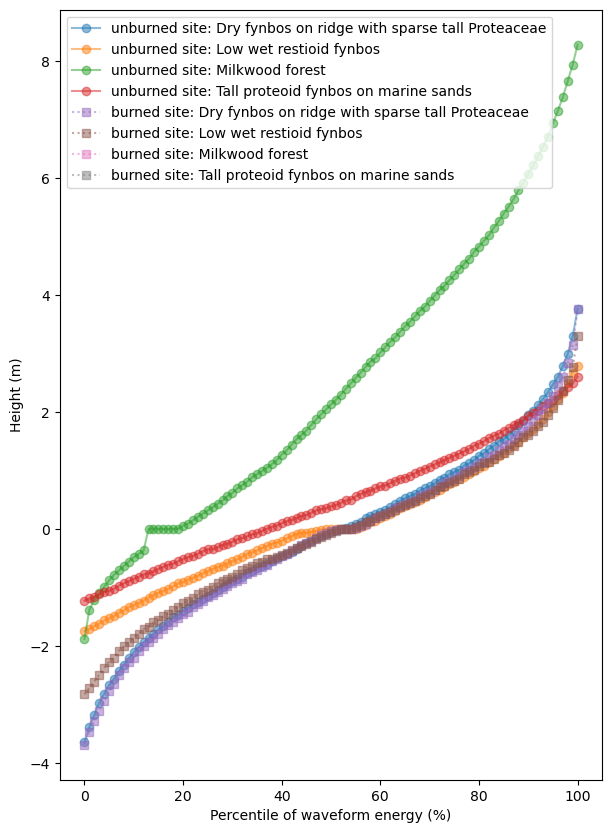

In [41]:
plotname = gedi_sub.Name.unique()
descrip = gedi_sub.description.unique()

fig, ax = plt.subplots(figsize=(7, 10))

for j, ditem in enumerate(descrip):
    desc_df = gedi_sub[gedi_sub.description == ditem]
    for i, item in enumerate(plotname):
        plot_df = desc_df[desc_df.Name == item]
        plot_df = plot_df.filter(like='RH').T
        plot_df.index = plot_df.index.str.strip('RH').astype(int)
        style = 's:'
        if ditem == "unburned":
            style = 'o-'
        plot_df.median(axis=1).plot(ax=ax, alpha=0.5,
                                    style=style, label=f"{ditem} site: {item}")
        plt.legend()
ax.set_xlabel("Percentile of waveform energy (%)")
ax.set_ylabel("Height (m)")
plt.show()